In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
cuda = torch.cuda.is_available() #GPU
batch_size = 32
epochs2 = 50

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [3]:
#global setting
T = 200
# beta = np.linspace(0.01, 0.03, T)
beta = 0.02*np.ones((T,))
alpha = 1 - beta
alpha_bar = np.cumprod(alpha,0)
sqrt_alpha_bar = np.sqrt(alpha_bar)

def forward_process(x_0, t):
    noise = np.random.multivariate_normal(np.zeros(28*28),np.eye(28*28)).reshape(28,28) # Sample noise from multivariate normal distribution with same size of X_0
    noise_image = x_0 * sqrt_alpha_bar[t-1] + noise * np.sqrt(1-alpha_bar[t-1])
    return noise, noise_image


In [4]:
t = torch.randint(0,200,(5,1))
alpha_bar[t]

array([[0.39482031],
       [0.05910859],
       [0.08003122],
       [0.03290083],
       [0.27445354]])

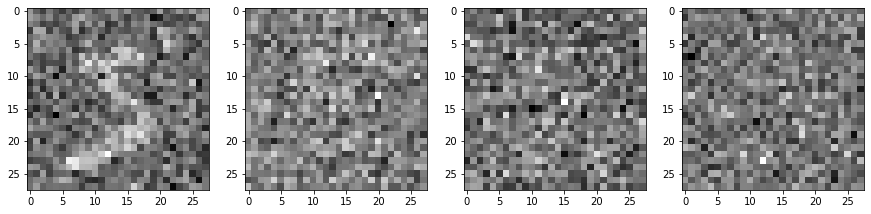

In [5]:
sample_mnist = next(iter(train_loader.dataset))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 100, 150, 200]):
    noise, noise_image = forward_process(sample_mnist.squeeze(),i)
    plt.subplot(1, 4, index+1)
    plt.imshow(noise_image.squeeze(), cmap='gray')
    
plt.show()

Text(0.5, 1.0, 'Alphas bar over t')

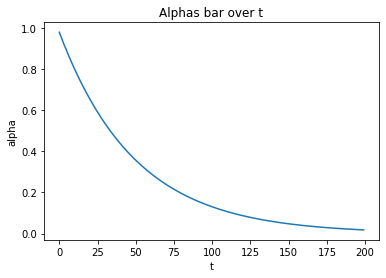

In [6]:
plt.plot(alpha_bar)
plt.ylabel("alpha")
plt.xlabel("t")
plt.title("Alphas bar over t")

In [7]:
beta = torch.from_numpy(beta).to(device).float()
alpha_bar = torch.from_numpy(alpha_bar).to(device).float()

In [8]:
from matplotlib.font_manager import X11FontDirectories
# neural network to learn epsilon(x_t,t). you can pla around with it, but we added it for convenience
# class DDPM(nn.Module):
#     def __init__(self):
#         super(DDPM, self).__init__()
#         self.t_emb_dim = 100
#         self.encConv1 = nn.Conv2d(1, 16, 5)
#         self.encConv2 = nn.Conv2d(16, 32, 5) # output torch size = [128, 32, 20, 20]
#         self.fc1 = nn.Linear(32*20*20, 32)
#         self.fct = nn.Linear(self.t_emb_dim, 32)
#         self.fc3 = nn.Linear(32, 32*20*20)
#         self.decConv1 = nn.ConvTranspose2d(32,16,5)
#         self.decConv2 = nn.ConvTranspose2d(16, 1, 5)

#     def forward(self, x,t):
#         #we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
#         #we therefore replace it by a set of features t_embedding that just represent several sine waves with different
#         #frequency
#         omegas = 2*np.pi*(torch.arange(self.t_emb_dim) / T).reshape(1,-1).to(device)
#         t_embedding = torch.cos(omegas*t.reshape(-1,1))
#         #Network structure: a simple network with two hidden layers. the first
#         # two fully connected laers are just there to merge the time embedding with the input vector
#         x = F.relu(self.encConv1(x))
#         x = F.relu(self.encConv2(x))
#         x = torch.flatten(x,1)
#         x = F.relu(self.fc1(x)+self.fct(t_embedding))
#         x = F.relu(self.fc3(x))
#         x = x.view(-1,32,20,20)
#         x = F.relu(self.decConv1(x))
#         return torch.sigmoid(self.decConv2(x))

class DDPM(nn.Module):
    def __init__(self):
        super(DDPM, self).__init__()
        self.t_emb_dim = 100
        self.fc1 = nn.Linear(28*28, 1000)
        self.fct = nn.Linear(self.t_emb_dim, 1000)
        self.block = nn.Sequential(nn.Linear(1000, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 28*28))

    def forward(self, x,t):
        #we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
        #we therefore replace it by a set of features t_embedding that just represent several sine waves with different
        #frequency
        omegas = 2*np.pi*(torch.arange(self.t_emb_dim) / T).reshape(1,-1).to(device)
        t_embedding = torch.cos(omegas * t.reshape(-1,1))
        #Network structure: a simple network with two hidden layers. the first
        # two fully connected laers are just there to merge the time embedding with the input vector
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)+self.fct(t_embedding))
        x = self.block(x)
        return x.view(-1, 1, 28, 28)

# class DDPM(nn.Module):
#     def __init__(self):
#         super(DDPM, self).__init__()
#         self.t_emb_dim = 100
#         self.block1 = nn.Sequential(nn.Conv2d(1, 32, 5, padding=2),
#                       nn.BatchNorm2d(32),
#                       nn.ReLU(),
#                       nn.Conv2d(32, 64, 5, padding=2))
#         self.fct = nn.Linear(self.t_emb_dim, 64)
#         self.block2 = nn.Sequential(nn.BatchNorm2d(64),
#                       nn.ReLU(),
#                       nn.Conv2d(64, 32, 5, padding=2),
#                       nn.BatchNorm2d(32),
#                       nn.ReLU(),
#                       nn.Conv2d(32, 1, 5, padding=2))

#     def forward(self, x,t):
#         omegas = 2*np.pi*(torch.arange(self.t_emb_dim) / T).reshape(1,-1).to(device)
#         t_embedding = torch.cos(omegas*t.reshape(-1,1))
#         x = self.block1(x)
#         x += self.fct(t_embedding).view(-1, 64, 1, 1) # add same value for the whole channel
#         x = self.block2(x)
#         return x

In [9]:
# def loss_f(Xs, model):
#     T= 200
#     beta = torch.linspace(0.0001, 0.02, T)
#     alpha = 1 - beta
#     alpha_bar = torch.cumprod(alpha,0).to(device)

#     batch_size = Xs.size(0)
#     t = torch.randint(0,200,(10,1)).expand(batch_size,10,1).reshape(batch_size*10,1)
#     Xs = Xs.expand(10,batch_size,-1,28,28).reshape(batch_size*10,28*28)
#     epsilon_t = torch.randn(Xs.shape).to(device)
#     X_t = (torch.sqrt(alpha_bar[t])*Xs+torch.sqrt(1-alpha_bar[t])*epsilon_t).reshape(batch_size*10,1,28,28)
#     loss = torch.mean(torch.sum((epsilon_t.reshape(-1,1,28,28)-model(X_t,t))**2,-1))
#     return loss

def loss_f(Xs, model, beta, alpha_bar):
    T= len(beta)
    batch_size = Xs.shape[0]
    t = torch.randint(0,T,(batch_size,1, 1, 1)).to(device)
    epsilon_t = torch.randn(Xs.size()).to(device)
    X_t = torch.sqrt(alpha_bar[t])*Xs + torch.sqrt(1-alpha_bar[t])*epsilon_t
    loss = torch.mean(torch.sum( ((epsilon_t - model(X_t, t))**2).view(batch_size, -1),-1))
    return loss

In [10]:
def train(epoch, beta, alpha_bar):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader,leave=False)):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        loss = loss_f(data, model, beta, alpha_bar)
        loss.backward() # calc gradients
        # print(torch.linalg.norm(model.fc1.weight.grad))
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.10f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, beta, alpha_bar):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            test_loss += loss_f(data, model, beta, alpha_bar).item()

    test_loss /= len(test_loader.dataset)
    
    print('====> Test set loss: {:.10f}'.format(test_loss))

In [11]:
model = DDPM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(1, 50 + 1):
    train(epoch, beta, alpha_bar)
    test(epoch, beta, alpha_bar)

====> Epoch: 1 Average loss: 19.0053639526


====> Test set loss: 14.5644709473


====> Epoch: 2 Average loss: 12.4980598663


====> Test set loss: 10.9477318878


====> Epoch: 3 Average loss: 9.8672608892


====> Test set loss: 8.9809300171


====> Epoch: 4 Average loss: 8.2942589851


====> Test set loss: 7.6629836899


====> Epoch: 5 Average loss: 7.2147966469


====> Test set loss: 6.8103426926


====> Epoch: 6 Average loss: 6.4486101888


====> Test set loss: 6.1826951569


====> Epoch: 7 Average loss: 5.8619317347


====> Test set loss: 5.5664139633


====> Epoch: 8 Average loss: 5.3768743528


====> Test set loss: 5.1507482468


====> Epoch: 9 Average loss: 4.9681465851


====> Test set loss: 4.7788299973


====> Epoch: 10 Average loss: 4.6247493286


====> Test set loss: 4.4595884888


====> Epoch: 11 Average loss: 4.3376824641


====> Test set loss: 4.1721735771


====> Epoch: 12 Average loss: 4.0641961508


====> Test set loss: 3.9861532616


====> Epoch: 13 Average loss: 3.8372713820


====> Test set loss: 3.7805569374


====> Epoch: 14 Average loss: 3.6711115407


====> Test set loss: 3.5505805122


====> Epoch: 15 Average loss: 3.4919238942


====> Test set loss: 3.4558589432


====> Epoch: 16 Average loss: 3.3533995611


====> Test set loss: 3.2987793999


====> Epoch: 17 Average loss: 3.2230782972


====> Test set loss: 3.1716721100


====> Epoch: 18 Average loss: 3.1121664853


====> Test set loss: 3.0665546501


====> Epoch: 19 Average loss: 2.9953873707


====> Test set loss: 2.9212293930


====> Epoch: 20 Average loss: 2.8701836250


====> Test set loss: 2.8023062412


====> Epoch: 21 Average loss: 2.7754435389


====> Test set loss: 2.8182777596


====> Epoch: 22 Average loss: 2.6868760984


====> Test set loss: 2.6431902557


====> Epoch: 23 Average loss: 2.6054415555


====> Test set loss: 2.5865730602


====> Epoch: 24 Average loss: 2.5415720110


====> Test set loss: 2.4995142036


====> Epoch: 25 Average loss: 2.4723820522


====> Test set loss: 2.4125640011


====> Epoch: 26 Average loss: 2.4315545569


====> Test set loss: 2.3666422249


====> Epoch: 27 Average loss: 2.3458528573


====> Test set loss: 2.3845565876


====> Epoch: 28 Average loss: 2.3005028961


====> Test set loss: 2.2785104702


====> Epoch: 29 Average loss: 2.2470072116


====> Test set loss: 2.1585529732


====> Epoch: 30 Average loss: 2.2260895519


====> Test set loss: 2.2039471123


====> Epoch: 31 Average loss: 2.1482425015


====> Test set loss: 2.1211834843


====> Epoch: 32 Average loss: 2.1192963440


====> Test set loss: 2.0177155315


====> Epoch: 33 Average loss: 2.0780244448


====> Test set loss: 2.0238607807


====> Epoch: 34 Average loss: 2.0633597186


====> Test set loss: 2.0122065529


====> Epoch: 35 Average loss: 2.0321507857


====> Test set loss: 2.0131324337


====> Epoch: 36 Average loss: 2.0003402688


====> Test set loss: 2.0422560837


====> Epoch: 37 Average loss: 1.9832804613


====> Test set loss: 1.9719768818


====> Epoch: 38 Average loss: 1.9412494884


====> Test set loss: 1.9290038090


====> Epoch: 39 Average loss: 1.9492447612


====> Test set loss: 1.8921002792


====> Epoch: 40 Average loss: 1.8798102158


====> Test set loss: 1.9007856339


====> Epoch: 41 Average loss: 1.8721729754


====> Test set loss: 1.8677013384


====> Epoch: 42 Average loss: 1.8763927360


====> Test set loss: 1.8415963911


====> Epoch: 43 Average loss: 1.8400808744


====> Test set loss: 1.8164546066


====> Epoch: 44 Average loss: 1.8287422861


====> Test set loss: 1.7473121531


====> Epoch: 45 Average loss: 1.7978607584


====> Test set loss: 1.7808439812


====> Epoch: 46 Average loss: 1.7692199469


====> Test set loss: 1.8037064255


====> Epoch: 47 Average loss: 1.7758393051


====> Test set loss: 1.7336445253


====> Epoch: 48 Average loss: 1.7837592231


====> Test set loss: 1.8345009926


====> Epoch: 49 Average loss: 1.7676699473


====> Test set loss: 1.7497853094


====> Epoch: 50 Average loss: 1.7508943863


====> Test set loss: 1.7591574072


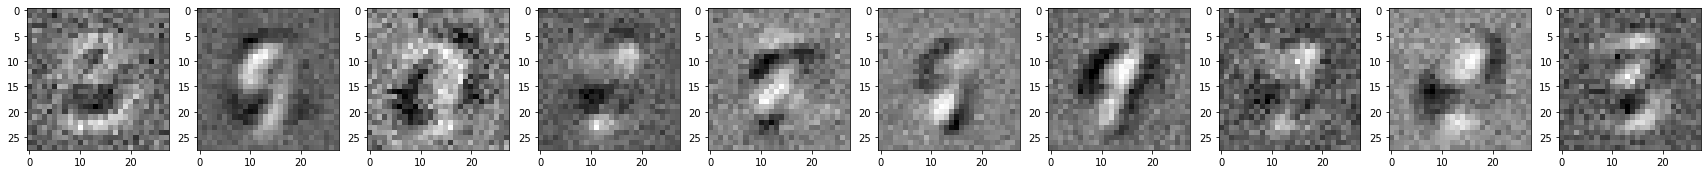

In [12]:
def generate_samples(model, num, beta, alpha_bar):
    T= len(beta)
    with torch.no_grad():
        Xs =  torch.normal(0.0,1.0,size=(num,1, 28, 28),dtype=torch.float32, device=device)
        for t in reversed(range(T)):
            eps_model = model(Xs, t*torch.ones(num).to(device))
            std_model = beta[t] / torch.sqrt(1-alpha_bar[t])
            mu = (Xs-eps_model*std_model)/torch.sqrt(1-beta[t])
            Xs = mu + torch.normal(0., 1., size=(num, 1, 28, 28), device=device) * torch.sqrt(beta[t])
    return Xs

num = 10
samples = generate_samples(model, num, beta, alpha_bar)

fig, ax = plt.subplots(ncols=num)
for i in range(10):
    ax[i].imshow(samples[i].cpu().squeeze(), cmap='gray')

fig.set_size_inches(30,30)
fig.show()

# beta = 0.02: train loss 2.56
# beta beta = np.linspace(0.00001, 0.02, T) loss: 6.52
# beta beta = np.linspace(0.0001, 0.02, T) loss: 6.7
# t_embed_dim=100 beta = 0.02 2.19
# T=500 loss: 1.5

In [13]:
import torch.distributions as t_dist

def cal_likelihood(model, num, beta, alpha_bar, test_loader, num_samples):
    T= len(beta)
    model.eval()
    with torch.no_grad():
        p_X0 = []
        for i, (data, _) in enumerate(tqdm(test_loader,leave=False)):
            result = []
            for j in range(num_samples):
                Xt1 = data.to(device).view(-1, 28*28)
                p_X_0_to_n = 0
                q_X_1_to_n = 0
                for t in range(T):  # transition Xt1 -> Xt2  Xt1 is closer to X_0
                    Xt2_given_Xt1 = t_dist.MultivariateNormal(torch.sqrt(1-beta[t]) * Xt1, beta[t] * torch.diag_embed(torch.ones_like(Xt1)))
                    Xt2 = Xt2_given_Xt1.sample()

                    q_X_1_to_n += Xt2_given_Xt1.log_prob(Xt2)
                    
                    mu = 1/torch.sqrt(1-beta[t]) * (Xt2 - beta[t]/torch.sqrt(1-alpha_bar[t]) * model(Xt2, t*torch.ones(Xt2.size(0)).to(device)).view(-1, 28*28))
                    Xt1_given_Xt2 = t_dist.MultivariateNormal(mu, beta[t] * torch.diag_embed(torch.ones_like(Xt1)))
                    p_Xt1_given_Xt2 = Xt1_given_Xt2.log_prob(Xt1)
                    p_X_0_to_n += p_Xt1_given_Xt2

                    Xt1 = Xt2

                p_X_0_to_n += t_dist.MultivariateNormal(torch.zeros_like(Xt1), torch.diag_embed(torch.ones_like(Xt1))).log_prob(Xt1)

                result.append(p_X_0_to_n - q_X_1_to_n)
            p_X0.append( torch.logsumexp(torch.stack(result), dim=0) - torch.log(torch.tensor(num_samples, device=device)) )
            print(p_X0[-1].mean())
        mean_log_p_X0 = torch.cat(p_X0).mean()
        print('mean log p(x): ', mean_log_p_X0)
        return mean_log_p_X0

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True, **kwargs) # change to a larger batch_size
num_samples = 5
cal_likelihood(model, num, beta, alpha_bar, test_loader, num_samples)


  2%|▎         | 1/40 [07:57<5:10:15, 477.32s/it]

tensor(-196.1051, device='cuda:0')


  5%|▌         | 2/40 [15:53<5:01:59, 476.84s/it]

tensor(-196.2311, device='cuda:0')


  8%|▊         | 3/40 [23:50<4:53:57, 476.69s/it]

tensor(-198.9998, device='cuda:0')


 10%|█         | 4/40 [31:46<4:45:55, 476.54s/it]

tensor(-197.0975, device='cuda:0')


 12%|█▎        | 5/40 [39:43<4:37:56, 476.48s/it]

tensor(-196.6929, device='cuda:0')


 15%|█▌        | 6/40 [47:39<4:29:59, 476.47s/it]

tensor(-197.5707, device='cuda:0')


 18%|█▊        | 7/40 [55:35<4:22:02, 476.44s/it]

tensor(-197.5468, device='cuda:0')


 20%|██        | 8/40 [1:03:32<4:14:06, 476.45s/it]

tensor(-197.0929, device='cuda:0')


 22%|██▎       | 9/40 [1:11:29<4:06:13, 476.56s/it]

tensor(-194.9932, device='cuda:0')


 25%|██▌       | 10/40 [1:19:25<3:58:16, 476.56s/it]

tensor(-196.1602, device='cuda:0')


 28%|██▊       | 11/40 [1:27:22<3:50:22, 476.62s/it]

tensor(-198.3766, device='cuda:0')


 30%|███       | 12/40 [1:35:19<3:42:25, 476.62s/it]

tensor(-196.6081, device='cuda:0')


 32%|███▎      | 13/40 [1:43:15<3:34:30, 476.67s/it]

tensor(-196.2307, device='cuda:0')


 35%|███▌      | 14/40 [1:51:12<3:26:32, 476.63s/it]

tensor(-197.0238, device='cuda:0')


 38%|███▊      | 15/40 [1:59:08<3:18:34, 476.59s/it]

tensor(-199.9650, device='cuda:0')


 40%|████      | 16/40 [2:07:05<3:10:38, 476.60s/it]

tensor(-197.8183, device='cuda:0')


 42%|████▎     | 17/40 [2:15:01<3:02:40, 476.55s/it]

tensor(-197.4270, device='cuda:0')


 45%|████▌     | 18/40 [2:22:58<2:54:41, 476.43s/it]

tensor(-196.8647, device='cuda:0')


 48%|████▊     | 19/40 [2:30:54<2:46:44, 476.41s/it]

tensor(-198.6442, device='cuda:0')


 50%|█████     | 20/40 [2:38:50<2:38:46, 476.34s/it]

tensor(-198.2456, device='cuda:0')


 52%|█████▎    | 21/40 [2:46:46<2:30:48, 476.25s/it]

tensor(-198.3707, device='cuda:0')


 55%|█████▌    | 22/40 [2:54:42<2:22:51, 476.18s/it]

tensor(-198.2930, device='cuda:0')


 57%|█████▊    | 23/40 [3:02:38<2:14:54, 476.13s/it]

tensor(-199.3604, device='cuda:0')


 60%|██████    | 24/40 [3:10:34<2:06:58, 476.17s/it]

tensor(-196.5052, device='cuda:0')


 62%|██████▎   | 25/40 [3:18:31<1:59:02, 476.15s/it]

tensor(-198.7960, device='cuda:0')


 65%|██████▌   | 26/40 [3:26:27<1:51:06, 476.21s/it]

tensor(-195.0905, device='cuda:0')


 68%|██████▊   | 27/40 [3:34:23<1:43:11, 476.28s/it]

tensor(-195.2545, device='cuda:0')


 70%|███████   | 28/40 [3:42:20<1:35:15, 476.32s/it]

tensor(-198.3956, device='cuda:0')


 72%|███████▎  | 29/40 [3:50:16<1:27:19, 476.34s/it]

tensor(-195.7614, device='cuda:0')


 75%|███████▌  | 30/40 [3:58:12<1:19:23, 476.33s/it]

tensor(-196.5637, device='cuda:0')


 78%|███████▊  | 31/40 [4:06:09<1:11:26, 476.25s/it]

tensor(-197.3996, device='cuda:0')


 80%|████████  | 32/40 [4:14:05<1:03:29, 476.19s/it]

tensor(-198.5926, device='cuda:0')


 82%|████████▎ | 33/40 [4:22:01<55:33, 476.23s/it]  

tensor(-197.4754, device='cuda:0')


 85%|████████▌ | 34/40 [4:29:57<47:37, 476.27s/it]

tensor(-196.9798, device='cuda:0')


 88%|████████▊ | 35/40 [4:37:54<39:41, 476.29s/it]

tensor(-198.2618, device='cuda:0')


 90%|█████████ | 36/40 [4:45:50<31:45, 476.32s/it]

tensor(-197.5266, device='cuda:0')


 92%|█████████▎| 37/40 [4:53:46<23:48, 476.31s/it]

tensor(-197.4588, device='cuda:0')


 95%|█████████▌| 38/40 [5:01:43<15:52, 476.32s/it]

tensor(-197.4960, device='cuda:0')


 98%|█████████▊| 39/40 [5:09:39<07:56, 476.26s/it]

tensor(-197.9240, device='cuda:0')


tensor(-193.3992, device='cuda:0')
mean log p(x):  tensor(-197.3578, device='cuda:0')


tensor(-197.3578, device='cuda:0')